<a href="https://colab.research.google.com/github/hariszaf/coi_dark_matter/blob/master/dark_matter_on_coi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://raw.githubusercontent.com/hariszaf/darn/main/figures/darn_logo.png" alt="drawing" width="200"/>

# Materials and methods for the Dark mAtteR iNvesigator (DARN) tool

### This notebook accompanies the manuscript: <br/> "*Bacteria are everywhere, even in your COI amplicon data!*"


# About this Google Collab file

Aim of this Google Collab notebook is to demonstrate 
how the COI reference tree was built and the main implementation steps
for building the `darn` tool.

`darn` is now available as a [Docker container](https://hub.docker.com/r/hariszaf/darn).

You may also find its source code on its [GitHub repo](https://github.com/hariszaf/darn).

The chunks of code with the following lines on top


```
#!/bin/bash

#SBATCH --partition=batch
#SBATCH --nodes=1
#SBATCH --nodelist=
#SBATCH --ntasks-per-node=20
```

are scripts that were performed as **jobs** on the [Zorba cluster](https://hpc.hcmr.gr/) called ***sbatch*** files. 

The ```#SBATCH``` lines describe the resources asked from the cluster for each job, e.g. RAM, cores, nodes etc.

# Introduction

The approach we used is thoroughly described at this [Full Stack Example](https://github.com/Pbdas/epa-ng/wiki/Full-Stack-Example) of the Evolutionary Placement Algorithn (`epa-ng`).

As you can see there, there are 5 steps to get the assignments of some query sequences to a tree. 

>**Step 1:**  *Selecting the reference sequences*

For this step, we had: 
* the Midori v2 database for the domain of eukaryotes
* all the COI related sequences from BOLD for the case of archaea and bacteria and all the DNA sequences that correspond to the `PF00115` PFam accession number. 

>**Step 2:**  *Building a reference alignment and tree*

For this step, as the scale of our analysis was way too big for a straightforward approach, we had some inner steps. 

The key idea was to keep as much of the diversity of each domain in a number of sequences able to proceed with. 

We used the `mafft` algorithm to get the alignments (multiple implementations were performed to address the challenges of each domain). 

And then we use the `phat` algorithm to get consnensus sequences from each domain (for the eukaryotes and bacteria cases).


>**Step 3:**  *Aligning the query sequences*

As suggested in this example, we used the `papara` tool align the query sequences of ours, against the refence MSA we built in step 2.



>**Step 4:**  *Placing the query sequences*


Sets of query sequencies were assigned to the reference tree using the `EPA-ng` algorithm, to explore environmental sequence samples.  


>**Step 5:**  *Visualization, post-analysis*

`darn` makes use of the `gappa examine assign` algorithm to build profiles with the number of assignments per domain, as input to build krona plots. 

--------

# COI sequences from all the three domains of Life

## Eukaryotes

For the case of COI the [Midori 2](https://academic.oup.com/bioinformatics/article/34/21/3753/5033384) database was used; specifically the MIDORI_UNIQ_GB239_CO1_RDP version including not only metazoa but sequnecess covering a wide range of eukaryotic taxa.

Here is its corresponding [website](http://www.reference-midori.info/) from where you can get the README file.

As mentioned in the README file of the Midori 2, there is a number after taxonomy each taxonomy level, representing the corresponding GenBank Taxonomy ID. 

As an example, here is the header of a Midori 2 sequence:
```
>MG559732.1.<1.>690	root_1;Eukaryota_2759;Discosea_555280;Flabellinia_1485085;order_Vannellidae_95227;Vannellidae_95227;Clydonella_218657;Clydonella sawyeri_2201168
```
This information is rather usefull, however we need to remove it for our analysis. 

To do so, we ran the following sed commands:

In [ ]:
sed 's/.1.<1.>[0-9]*//g; s/_[0-9]*//g' MIDORI_UNIQ_GB239_CO1_RDP.fasta > MIDORI_UNIQ_GB239_CO1_RDP_no_taxids.fasta

In addition, as Midori 2 includes more than one sequences for a species in many cases, we need to keep only one. To do so, we used the [`clear_the_doubles.py`](https://github.com/hariszaf/coi_dark_matter/blob/protein_level/sequences_of_life/eukaryota/clear_the_doubles.py) script. 

And then we ran the following sed command to get rid of the ```root;``` prefix in the taxonomies.

In [ ]:
sed -i 's/root;//g' MIDORI_single_species_input_for_PHAT_algo.fasta 

After that, we end up with **183.330 sequences** while the initial number of this Midori 2 version is **1.315.378**. 

These sequences are now our Eukaryotes COI dataset and need to get aligned. That is a huge task from a computanional point of view! 
 

So, in terms of getting the alignment, a straightforward alignment is not possible. 

A ***core set*** of 500 sequences was used to build an alignment which was later used to align all the rest using this first as a base. 

**Attention!**
As our sequences are from a reference database, we assume that are all of the same quailty.

To figure out what sequences to use for the core set we need to find the longest ones from each phylum. 


Here is the number of sequences for each phylum and the number of the **longest** sequences we got to build the *core set*.

| Phylum | # of occurences |  # of seqs in core aln |
|:------:|:--------------------:|:--------------------:|
| Acanthocephala | 134 | 4 |
| Annelida | 2.870 | 16 |
| Apicomplexa | 356 | 4 |
| Arthropoda | 124.082 | 147 |
| Ascomycota | 587 | 4 |
| Bacillariophyta | 185 | 4 |
| Basidiomycota | 282 | 4 |
| Blastocladiomycota | 3 | 1 |
| Brachiopoda | 36 | 2 |
| Bryozoa | 215 | 4 |
| Cercozoa | 3 | 1 |
| Chaetognatha | 36 | 2 |
| Chlorophyta | 145 | 4 |
| Chordata | 29.157 | 97 |
| Chytridiomycota | 7 | 1 |
| Ciliophora | 218 | 4 |
| Cnidaria | 1.774 | 16 |
| Cryptomycota | 1 | 1 |
| Ctenophora | 19 | 2 |
| Cycliophora | 2 | 1 |
| Dicyemida | 12 | 2 |
| Discosea | 64 | 2 |
| Echinodermata | 1.541 | 16 |
| Endomyxa | 2 | 1 |
| Entoprocta | 17 | 2 |
| Euglenozoa | 60 | 2 |
| Evosea | 11 | 2 |
| Gastrotricha | 62 | 2 |
| Gnathostomulida | 9 | 1 |
| Haptista | 18 | 2 |
| Hemichordata | 9 | 1 |
| Heterolobosea | 23 | 2 |
| Imbricatea | 8 | 1 |
| Kinorhyncha | 32 | 2 |
| Mollusca | 11.980 | 48 |
| Mucoromycota | 71 | 2 |
| Nematoda | 1.413 | 16 |
| Nematomorpha | 22 | 2 |
| Nemertea | 250 | 4 |
| Onychophora | 85 | 2 |
| Perkinsozoa | 2 | 1 |
| Phoronida | 12 | 2 |
| Placozoa | 2 | 1 |
| Platyhelminthes | 1.535 | 16 |
| Porifera | 813 | 4 |
| Priapulida | 4 | 1 |
| Rhodophyta | 1.741 | 16 |
| Rotifera | 228 | 4 |
| Streptophyta | 1.595 | 16 |
| Tardigrada | 136 | 4 |
| Tubulinea | 1 | 1 |
| Xenacoelomorpha | 81 | 2 |
| Zoopagomycota | 3 | 1 |



 The [`keep_longest_single_line_seqs.py`](https://github.com/hariszaf/coi_dark_matter/blob/protein_level/sequences_of_life/eukaryota/keep_longest_single_line_seqs.py) script was build to return the $n$ longest sequences from each phylum from the `MIDORI_single_species_input_for_mafft.fasta` file.

Once we have the *core set* sequences, we need to remove them from the `MIDORI_single_species_input_for_mafft.fasta` file.

To do this we performed the [`get_the_non_core_seqs.py`](https://github.com/hariszaf/coi_dark_matter/blob/protein_level/sequences_of_life/eukaryota/get_the_non_core_seqs.py) script.


Now we are able to perform the two-steps alignment as suggested from the mafft-team (see Extras).

[Here](https://github.com/hariszaf/coi_dark_matter/blob/protein_level/sequences_of_life/eukaryota/mafft_two_steps_job.sh) is the sbatch script we used for this step. 

**Alignment of the Midori 2 eukaryotic sequences**

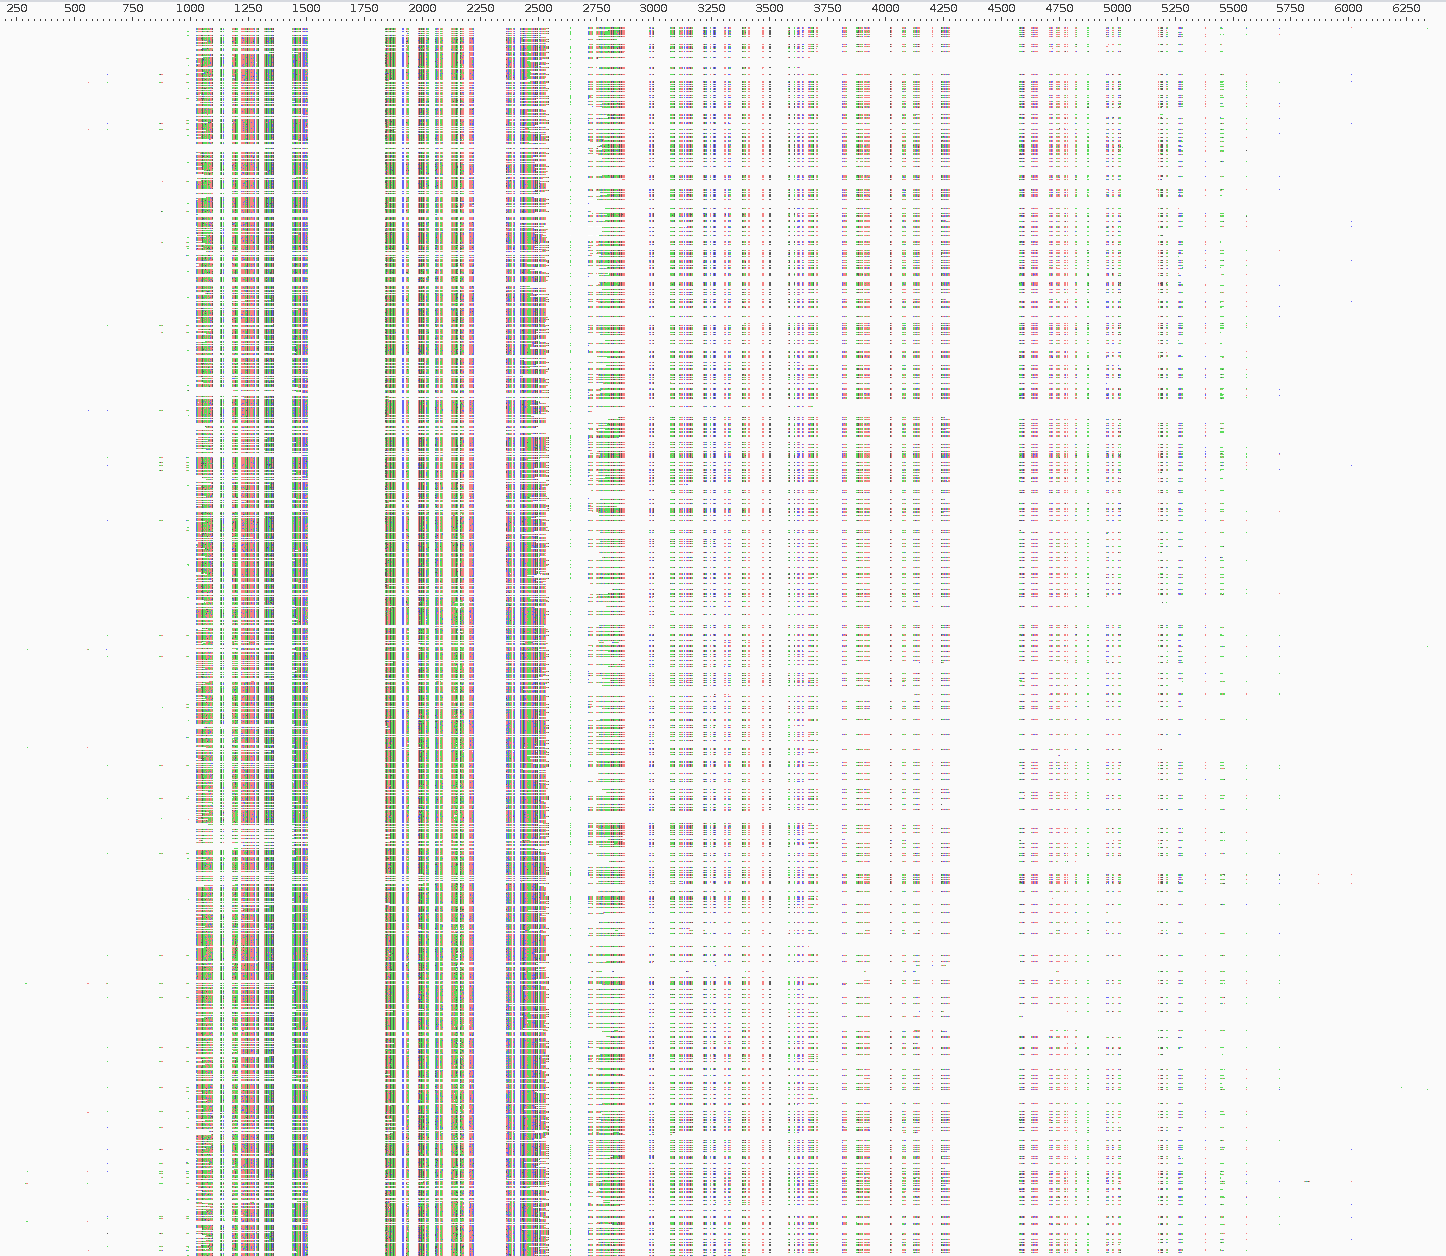

Now we just replace the last space in the taxonomy of each sequence with an underscore ("_") so Phat can take is as input. 

```
sed -i -E 's/(.*)\s/\1_/' full_midori_alignment.aln > full_midori_alignment_underscore.aln 
```

and we keep the taxonomies in a seperate file too. 

```
awk -F "\t" '{if ($0 ~ />/ ) {print $2}}' full_midori_alignment_no_taxon_levels.aln 
```



and we are ready to go for the Phat step.

When using PhAT: 

* the `.fasta` file needs to have only a single ` ` (space) between the id and its taxonomy
* if a taxonomy has spaces or tabs, it will be broken 
* all taxonomies in `taxonomy-file` need to be present in the `sequence-file`. Thus, it is always a good practice to build the `sequence-file` and then extract the taxonomies from that.



[Here](https://github.com/hariszaf/coi_dark_matter/blob/protein_level/sequences_of_life/eukaryota/phat_job_eukaryotes.sh) is the `sbatch` script used to run `phat` for the case of eukaryotes. 

## Bacteria & Archaea

Two ways for getting COI sequences were followed: 
* DNA sequences were directly retrieved through the API of the BOLD database
* through the PFam id for COI, protein sequences were found and from there the coordinates to the corresponding genomes were extracted. Finally, dna sequences from these genome parts were retrieved. 

With resepct to method (1), the exact same steps followed in the case of bacteria, were also followed for archaea.


In addition, when method (2) was ran, sequences from both bacteria and archaea were retrieved. 

Therefore, we will discuss bacteria- and archaea-relates steps at the same time. All the hyperlinks point to the bacteria-related scripts.

### **DNA COI sequnces from BOLD**

To get the bacteria and archaea COI sequences we used the [BOLD API](https://v3.boldsystems.org/index.php/resources/api).

From [Silva database browser](https://www.arb-silva.de/browser/) we got the list of phyla of interest and searched for those in BOLD.

By running the following command for the various phyle, a `.xml` file was retrieved for each of those present in BOLD, in this example Proteobacteria. 

In [ ]:
TAXON="Proteobacteria"
curl -o Proteobacteria http://v3.boldsystems.org/index.php/API_Public/combined?taxon=$TAXO

To get the info needed we had to parse these `.xml` files. 

To this end, we developed the [`parse_xml_files.py`](https://github.com/hariszaf/coi_dark_matter/blob/protein_level/sequences_of_life/bacteria/BOLD/parse_xml_files.py) which builds the `ncbi_ids_and_seq.tsv` file. 

From this file we keep the ncbi taxonomy ids and the phylum of each sequence in a file called `ids`.

In [ ]:
awk '{print $1"\t"$2 }' ncbi_ids_and_seq.tsv > ids
awk -F "\t" '{print $1}' ids > ncbi_ids

We make a precursor `.fasta` file keeping just the ncbi taxonomy id as a title and its corresponding sequence.

In [ ]:
sed 's/^/>/' ncbi_ids_and_seq.tsv | sed 's/\(.*\)\t/\1\n/' | sed 's/\t.*//' > ncbi_ids_and_seq.fasta

In the following chuncks of code the corresponding NCBI ids and the complete taxonomies are completed. To do so, under `ncbi_new_taxdump` directory you need to add the NCBI dump files you may find under the [FTP of the NCBI taxonomy database](https://ftp.ncbi.nih.gov/pub/taxonomy/).

In [ ]:
while read TAX_ID;  
do
    awk -v var=$TAX_ID '$1==var' /home1/haris/Desktop/ncbi_taxonomy_dump/fullnamelineage.dmp | awk -v var=$TAX_ID -F "|" '{print var "\t" $3 " " $2}' ;  
done < ncbi_ids > temp.taxonomy

and then..

In [ ]:
sed -i 's/; /;/g ; s/cellular organisms;//g' temp.taxonomy
sed -i 's/;[[:blank:]]\+/;/g ; s/ /_/g' temp.taxonomy

Once the taxonomy file was ready, the [`get_full_taxonomies.awk`](https://github.com/hariszaf/coi_dark_matter/blob/protein_level/sequences_of_life/bacteria/BOLD/get_full_taxonomies.awk) script was performed to build the complete `.fasta` file. 

And in order to make the output file a multiline fasta.

In [ ]:
sed '/^>/!s/.\{80\}/&\n/g' bold_bacteria_full_taxonomy_seq.fasta > multiline_bold_bacteria_full_taxonomy_seq.fasta 

Likewise, for the case of Archaea from BOLD:



| Domain | # of seqs | # of unique families | 
|:----:|:-----:|:-----:|
| Bacteria | 3,857 | 218 | 
| Archaea | 127 | 13 |


### **Protein sequences from PFam - mapping to their DNA records**

After search the PFam database, the loci of our interest COX1 was identified as the family [PF00115](http://pfam.xfam.org/family/PF00115). 

All the 16,128 protein sequnces of the family, coming from **5,706** species, were downloaded and their ids were kept. 


In this case, we will see what sequences come from bacteria, archaea and eukaryotes, once we have their full taxonomies.


In [ ]:
# parse and keep the ids
cat PF00115_full.txt | grep ">" | awk -F "_" '{print $1}' | sed 's/>//g' > uniprot_ids.tsv

# split the ids to files of 200 entries on the ids/ directory
split -l 200 uniprot_ids.tsv

To get the DNA sequences that correspond to the proteins retrieved, the coordinates of the sequences in the corresponding genomes are needed. 

To get them, the [`get_coordinates.sh`](https://github.com/hariszaf/coi_dark_matter/blob/protein_level/sequences_of_life/pfam/get_coordinates.sh) was built.

Once the coordinates and the corresponding genomes ids have been extracted, the DNA sequences of interest can be retrieved.

To do so, the unique entries were kept and the coordinate were isolated.

In [ ]:
sed 's/\/coded_by="complement(//g ; s/\/coded_by="//g ; s/)"//g ; s/"//g' coordinates.tsv > tmp

more tmp | sort | uniq | sort > tmp2
mv tmp2 coordinates.tsv 

sed -i 's/<//g ; s/>//g ; s/join(//g' coordinates.tsv 
mkdir coordinates 
cp coordinates.tsv coordinates/
split -l 200 coordinates.tsv
rm coordinates.tsv

As Midori's longest sequence was at 1992bp and most of its sequences were less than 1600bp long, a sequence length threshold for the COI derived from the PFam related DNA sequences was set at 1800bp.

To finally, get the DNA sequences the [`get_dna_seq.py`](https://github.com/hariszaf/coi_dark_matter/blob/protein_level/sequences_of_life/pfam/get_dna_seq.py) script was built and performed.


In addition, the NCBI id and the full taxonomy for each sequence were needed in this case too. 

So,we used the 
`nucl_gb.accession2taxid` and the
`nucl_wgs.accession2taxid` files
from the [NCBI Taxonomy FTP server](https://ftp.ncbi.nlm.nih.gov/pub/taxonomy/accession2taxid/). 


From the `downloads.log` file, we can keep the accession numbers needed for the mapping. 
To do so, we run

In [ ]:
sed 's/\..*//g' downloads.log  > accessions

And now, using the [`get_full_taxonomies.awk`](https://github.com/hariszaf/coi_dark_matter/blob/protein_level/sequences_of_life/bacteria/BOLD/get_full_taxonomies.awk) scirpt we were able to do the mapping between a NCBI id and its complete taxonomy. 

For example, 

```
2320083   Bacteria;Terrabacteria_group;Firmicutes;Clostridia;Eubacteriales;Clostridiaceae;Butyricicoccus;unclassified_Butyricicoccus;Butyricicoccus_sp._1XD8-22
```

As an accession number comes from a gene entry or from a genome one, we run the same script against those 2 mapping files and then we concatenate their findings.

In [ ]:
cat PAIRS_wgs PAIRS_gb > PAIRS

Finally, using the [`build_seq_file.awk`](https://github.com/hariszaf/coi_dark_matter/blob/protein_level/sequences_of_life/pfam/build_seq_file.awk) the .fasta file with both the NCBI id, the accession number and the sequence, is ready.

Some modifications are thus needed.

In [ ]:
sed -i 's/; /;/g ; s/cellular organisms;//g' IDS_TAXA
sed -i 's/;[[:blank:]]\+/;/g ; s/ /_/g' IDS_TAXA

Stats for PFam

| Domain | # of seqs | # of unique families | 
|:----:|:-----:|:-----:|
| Bacteria | 9,154 | 358 | 
| Archaea | 217 | 12 |


### Concatenate sequences from BOLD and PFam related

As two resources were used to obtain sequences data, their results had to be combined to move on with our pipeline. 

In some few cases, we found strains of the same genus having the exact same COI sequence, e.g sequencs found from the strains  *Sulfolobus_acidocaldarius_DSM_639*,
*Sulfolobus_acidocaldarius_N8* and
*Sulfolobus_acidocaldarius_Ron12/I*
were identical. 

#### Bacteria

From both BOLD and PFam databases 13,027 sequences were retrieved.  
However, the unique sequences found were 11,420. 
PFam derived sequences increased 3-fold the number of the reference sequence dataset.

However, to check what is the true benefit of adding PFam oriented sequences in our dataset, we need to check the taxa that they correspond to and see if taxa that were not included before (in the BOLD dataset), are now present in our amended dataset. 

Using only BOLD, the 3,859 sequences that were retrieved, represented **3,859** unique NCBI Taxonomy Ids.

The unique NCBI Taxonomy Ids from both BOLD and PFam seqences are **6,228**.

This proves that adding sequences found in PFam, adds an important number of taxa in the amended dataset. 

However, to check its true value we also have to: 
* check the higher taxonomy of the new taxa (i.e. how many new genera, families, orders etc have been added with the inclusion of the new sequences)
*check the alignment of the 11,420 sequences to identify potential gaps and mismatches between the two datasets (BOLD and PFam). 

In the initial **BOLD dataset**, we had sequences from **218** bacterial families.

In the **amended dataset**, we have now sequences covering **375 families**; while indicatively, the bacterial families present in [Genome Taxonomy Database](https://gtdb.ecogenomic.org/stats/r202) are currently **2,886**.

That means, 157 families were added using information from **PFam**.

| Source | # of unique seqs | # of unique families | 
|:----:|:-----:|:-----:|
| BOLD | 2,267 | 220 | 
| PFam-oriented | 9,153 | 353 |
| altogether | 11,420 | 375 |

As mentioned, the 11,420 sequences however, are from a set of 6,228 unique NCBI Taxonomy IDs

Here is the sequence alignment of the BOLD COI Bacteria sequences using the script [`mafft_two_steps_job.sh`](https://github.com/hariszaf/coi_dark_matter/blob/protein_level/sequences_of_life/bacteria/alltogether/mafft_two_steps_job.sh).

This is the same process as in the eukaryotes case, for more see above. 


Once the complete alignment is done, we need to trim it. 
As [ClipKIT](https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.3001007) removes everything from the header of the sequnce after the fist blank, we make a small trick to keep all the information of the header.


In [ ]:
sed 's/\t\| /***/g' aligned_bacteria.aln > star_aligned_bascteria.aln

And then we run the ClipKIT tool. 

After that, we run the following command to keep the header format as tab seperated.

In [ ]:
sed 's/\*\*\*/ /g' trimmed_star_aligned_archaea.aln > trimmed_aligned_archaea.aln

And to keep the taxonomies present in our trimmed alignment: 

In [ ]:
grep ">" trimmed_aligned_bascteria.aln | awk -F " " '{print $2" " $3}' > taxonomies_present.tsv

In [ ]:
grep ">" trimmed_aligned_bascteria.aln | awk -F " " '{print $2":" $3}' > taxonomies_present_semicolon.tsv
sed -i 's/\:$//' taxonomies_present_semicolon.tsv

To use Phat based on the taxonomy 

we had to make a small trick:




In [ ]:
sed 's/;/\t/g' taxonomies_present.tsv | \
   awk -F "\t" '{if ($0 ~ /aceae/)  { for(i=1; i<=NF; i++) {if ($i ~ /aceae/)  {  printf($1 "\t" $2 "\t" $3 "\t" $4 "\t"$5 "\t");  for(x=i;x<=NF;x++) {printf("%s%s",$x,x==NF?RS:OFS="\t")};  break}}} else {print $0}  }' > cheat_taxonomies

--------------------------------------------------------------------------------------------

#### Archaea

Here is an overall of the sequences retrieved regarding archaeal taxa. 


| Source | # of unique seqs | # of unique families | 
|:----:|:-----:|:-----:|
| BOLD | 107 | 13 | 
| PFam-oriented | 217 | 12 |
| altogether | 323 | 15 |



And here is a table with the families retrieved from each of the resources used. 

| Family      | BOLD | PFam     |
| :---        |    :----:   |          ---: |
| Archaeoglobaceae |  &#9744; | &#9745; | 
| Desulfurococcaceae | &#9745; | &#9745; |
| Ferroplasmaceae | &#9745; | &#9744; |
| Haloarculaceae | &#9745; | &#9745; |
| Halobacteriaceae | &#9745; | &#9745; |
| Halococcaceae | &#9745; | &#9745; |
| Haloferacaceae | &#9745; | &#9745; |
| Halorubraceae | &#9745; | &#9745; |
| Methanoperedenaceae | &#9744; | &#9745; |
| Natrialbaceae | &#9745; | &#9745; |
| Nitrosopumilaceae | &#9745; | &#9745; |
| Nitrososphaeraceae | &#9745; | &#9745; |
| Picrophilaceae | &#9745; | &#9744; |
| Sulfolobaceae | &#9745; | &#9745; |
| Thermoproteaceae | &#9745; | &#9744; |


The total sequences retrieved were then aligned using the [`mafft_orientation_job.sh`](https://github.com/hariszaf/coi_dark_matter/blob/protein_level/sequences_of_life/archaea/alltogether/mafft_orientation_job.sh) script. 

Once the alignment was complete, the [`ClipKIT`](https://github.com/jlsteenwyk/clipkit) alignment trimming toolkit was used to trim it. 

Here is the archaeal COI sequences alignment:
<img src="https://drive.google.com/uc?id=15PFTc5MKUHOH916-u7_iHY2WqCFOVcH5">


Finally, the trimmed alignment was used as input to the [`phat`](https://github.com/lczech/gappa/wiki/Subcommand:-phat) algorithm, subcommand of the `prepare` module of the `gappa` package.

[Here](https://github.com/hariszaf/coi_dark_matter/blob/protein_level/sequences_of_life/archaea/alltogether/phat.sh) you may find the relative `sbatch` file used. 

Once this step was completed, the final consensus sequences used for building our reference tree, were ready. 







# Build the phylogenetic tree

After getting the consensus sequences for all the three domains of life, we need to build a single MSA for all the sequences derived. 

To do this, we need to remove all the "-" from the sequences in the alignment of each domain and then build our final MSA using the total number of these sequences. 

This is final MSA is the one we will use to build our magic tree.



To this end, we first concatenate all the consensus sequences to a single file and remove the "-".

In [ ]:
cat eukaryotes_consensus.fasta bacteria_consensus.fasta archaea_consensus.fasta > all_seqs_multiline.fasta
awk '{if(NR==1) {print $0} else {if($0 ~ /^>/) {print "\n"$0} else {printf $0}}}' all_seqs_multiline.fasta > all_seqs_singleline.fasta
sed 's/-//g ; /^$/d' all_seqs_singleline.fasta > non_period_all_seqs_singleline.fasta

Finally, by making use of the [`align_consensus_seqs.sh`](https://github.com/hariszaf/coi_dark_matter/blob/protein_level/build_tree_of_life/consensus_seqs/align_consensus_seqs.sh) script to implement MAFFT, the reference MSA for the COI phylogenetic tree was built. 


Once completed, the [`ClipKIT`](https://jlsteenwyk.com/ClipKIT/advanced/index.html) was used to trim the reference MSA. 

--------------------------------------

### Edit the tree and the MSA taxonomies

In [ ]:
sed -i 's/Bacteroidetes_Chlorobi/Bacteroidetes\/Chlorobi/g' magicTree.bestTree 
sed -i  's/\_delta\_epsilon/\_delta\/epsilon/g' magicTree.bestTree
sed -i  's/\_Cyanobacteria\_Melainabacteria/\_Cyanobacteria\/Melainabacteria/g' magicTree.bestTree
sed -i  's/Proteobacteriadelta\_epsilon/Proteobacteria\_delta\/epsilon/g' magicTree.bestTree 
sed -i  's/Nitrospinae\_Tectomicrobia/Nitrospinae\/Tectomicrobia/g' magicTree.bestTree
sed  -i 's/\_\_\_/\_=\_/g' magicTree.bestTree

sed -i  's/Proteobacteriadelta/Proteobacteria\_delta/g' magic_tree_aln.phy
sed -i  's/Proteobacteriadelta/Proteobacteria\_delta/g' magic_tree_aln.fasta

# Assigning the COI dark matter on the magic tree


Once the tree is ready, there is only one thing left to do. We need to assign query sequences, i.e sequences coming from COI from environmental samples, the taxonomy of whom has not been verified. 

To do this, we need to build a new MSA, **based on** the one we already have from the consensus sequences. We *concatenate* the query sequences on the initial MSA to build a new one, using the `papara` algorithm. 

Once this is done, we use the evolutionary placement algorithm, `epa-ng`, to make the assignment. 


Finally, we need a visualization tool, to allow us to see the actual placements of our query sequences on the magic tree. 


## a second MSA: consensus + queries

As already mentioned, we used the `PaPaRa` algorithm.

Before of that, we have to make our queries in a format `PaPaRa` supports, meaning multiline fasta.

Now we are ready to go for the `PaPaRa` step.

From the [Full Stack Example](https://github.com/Pbdas/epa-ng/wiki/Full-Stack-Example)

*Note the* `-r` *option: this is vital to ensure comparability between different query files for the same reference tree, as it forces papara not to add any sites to the original reference alignment!*

*Next, before the actual placement can commence, we need to explicitly prepare the input, as epa-ng (currently) only accepts separate query and reference alignment files, both in fasta (or bfast) format. Papara, for example, outputs the aligned queries together with the reference MSA, in phylip format.*

*This can be done directly with epa-ng now, using the* `--split` *function:*

`epa-ng --split ref_alignment query_alignments+*`

> **epa-ng takes only `.fasta` files as input!**

from PHYLIP to FASTA 

```bash=
awk '{print ">"$0}' my_input.phy > tmp
sed 's/ \{1,\}/ /g ; s/ /\n/' tmp > tmp2
sed '/^>/!s/.\{80\}/&\n/g' tmp2 >  my_input.fasta
```

## Placing query sequences on the magic tree

Once we have this second MSA, we are now ready to go for the last step of our analysis. The assignment of the queries sequences on the magic tree of life.

For more about this step and how `darn` is making use of the reference COI phylogenetic tree built, you may see the [`darn.sh`](https://github.com/hariszaf/darn/blob/main/darn.sh) script.

👍 🎉 **Thanks for reading!**
